# Projet Spark - Logistic gradient descent in batch and minibatch

## Victor Journe, Ludovic Lelievre

This project deals with the implementation of the Logistic Gradient Descent in a distributed manner with **Spark**.
A minibatch implementation is proposed as well. 
This notebook provides the Spark codes, whereas the repport gives the theorical justifications and the parallel architecture chosen.

In [1]:
import pandas
import datetime
import numpy as np
from sklearn.metrics import accuracy_score
import os
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
PATH = "/Users/ludoviclelievre/Dropbox/Docs Share/projet_spark/"

In [ ]:
PATH = "C:\Users\KD5299\Documents\Dropbox\Docs Share\projet_spark/"

In [3]:
# data base importation
df = pandas.read_csv(os.path.join(PATH,"ds_spark.txt"), sep=",", encoding="utf-8", index_col=0,parse_dates=True)
df.head()

,100MW,100MW_-m08,100MW_m08,-300MW,-300MW_-m08,-300MW_m08,R2_D_P_tot_s2,R2_D_P_tot_m296,Max,Max_-m08,...,NRV_s2,NRV_s3,NRV_s4,NRV_m18,R2_I_P_tot_s2,R2_I_P_tot_m296,PPOS,hour,month,day
2014-01-03 17:45:00,66.46,66.406667,64.925556,-156.7,-156.7,-156.7,22.77,20.568105,372.49,351.343333,...,16.322,86.499,147.100,62.027625,66.46,67.684842,110.11,17,1,4
2014-01-03 18:00:00,66.46,66.424444,65.231111,-156.7,-156.7,-156.7,22.77,20.544421,352.44,348.282222,...,111.153,16.322,86.499,84.259125,66.46,67.609053,140.25,18,1,4
2014-01-03 18:15:00,66.55,66.370000,65.546667,-156.7,-156.7,-156.7,22.77,20.454211,352.44,347.448889,...,177.231,111.153,16.322,105.984875,66.46,67.502316,140.25,18,1,4
2014-01-03 18:30:00,65.86,66.084444,65.785556,-156.7,-156.7,-156.7,21.54,20.419158,352.44,346.615556,...,208.363,177.231,111.153,129.275125,66.46,67.344421,140.25,18,1,4
2014-01-03 18:45:00,66.55,65.875556,66.101111,-156.7,-156.7,-156.7,21.54,20.382105,352.44,345.782222,...,213.468,208.363,177.231,130.510375,66.55,67.188947,140.25,18,1,4


The histogram below depicts the market price ditribution across 3 years of history. The two classes that we want to classify are the two modes of the distribution 

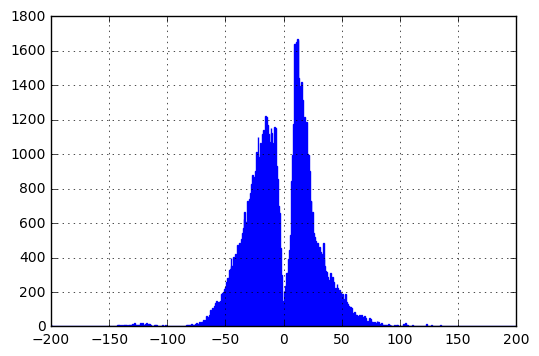

In [4]:
# histogramme prix a la baisse/prix a la hausse
(df['PPOS']-df['BELIX PRICE']).hist(range = (-200, 200), bins=500, edgecolor = 'b')

In [5]:
# Creation of the constant = 1
df['constante'] = 1
# on cree la variable target: 0 = prix a la baisse; 1 = prix à la hausse
df['target'] = ((df['PPOS']-df['BELIX PRICE']) > 0)*1 
# on supprime la variable 'PPOS' du dataframe
df = df.drop('PPOS',axis=1)

In [7]:
# target number in train and test
# train set
train_set = df[df.index<datetime.datetime(2016,1,1)]
print('target = 0 dans train set: ',sum(train_set['target']==0))
print('target = 1 dans train set: ',sum(train_set['target']==1))
# test set
test_set = df[df.index>=datetime.datetime(2016,1,1)]
print('target = 0 dans test set: ',sum(test_set['target']==0))
print('target = 1 dans test set: ',sum(test_set['target']==1))

target = 0 dans train set:  35328
target = 1 dans train set:  33589
target = 0 dans test set:  14049
target = 1 dans test set:  11200


In [ ]:
from sklearn import preprocessing
# scaling of input du train_set
dim = train_set.shape[1]-2
scaler = preprocessing.StandardScaler().fit(train_set[range(0,dim)])
train_set[range(0,dim)] = scaler.transform(train_set[range(0,dim)])
# on utilise la meme transformation sur les inputs du test_set
test_set[range(0,dim)] = scaler.transform(test_set[range(0,dim)])

In [7]:
# index change
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

In [8]:
# dataframes saving without columns name
train_set.to_csv(os.path.join(PATH,"rdd_train.txt"),sep=";", encoding="utf-8", index=True, header=None)
test_set.to_csv(os.path.join(PATH,"rdd_test.txt"),sep=";", encoding="utf-8", index=True, header=None)

In [8]:
# RDD creation
rdd_train = sc.textFile(os.path.join(PATH,"rdd_train.txt"))
rdd_test = sc.textFile(os.path.join(PATH,"rdd_test.txt"))
rdd_train.take(1)

['0;0.382353466831;0.390549001546;0.254153021506;-0.985481847205;-1.07535007251;-1.07541225434;0.629701841912;0.477208130853;-0.0595048720004;-0.0630483280877;-0.0629883762354;0.629746144603;0.819810924445;0.794148292457;-0.329721368809;-0.26414752119;-0.552103012176;-0.288043399569;-2.15555865876;-0.0228934408005;-0.0316498727045;-0.0316463471013;0.445328436201;0.447077116971;0.462301900044;0.173489418499;0.366086618232;0.00763729138891;-0.425790210066;-0.495864809359;-0.495842885975;0.632906587889;0.632906587889;0.626913583653;0.5984872661;0.532055210379;5.17249285239e-19;0.574299291037;0.572886939901;0.509520317945;0.509524720346;0.541056526614;0.248774175336;0.318768488467;0.958626401926;0.164792404751;0.752241790588;1.25951363046;0.704543829175;0.382360477503;0.575154998737;0.791668679539;-1.61660884298;0.498648010911;1;1']

# Batch Gradient Descent

In [9]:
from operator import add
def logistic_funct(x):
    return (1. / (1. + np.exp(-np.dot(wb.value,x))))
def transform_rdd(row):
    values = row.split(";")
    index = values[0]
    x = np.array([float(i) for i in values[1:-1]])
    y = float(values[-1])
    return index,x,y

In [10]:
def logistic_gradient(row):
    x=row[1]
    y=row[2]
    lg = logistic_funct(x)
    penal = np.append(wb.value[:-1],0)
    return x*(lg-y)+0.1*penal

In [11]:
def get_confusion_matrix(row):
    x=row[1]
    y=row[2]
    lg = logistic_funct(x)
    pred = 1*(lg>0.5)
    return (int(y),pred)

In [12]:
def cost_func(row):
    x=row[1]
    y= int(row[2])
    lg = logistic_funct(x)
    wx = np.dot(wb.value,x)
    #return (1-y)*wx+np.log(1+np.exp(-wx))+0.1*np.dot(wb.value[:-1],wb.value[:-1])/2
    return -(y*np.log(lg)+(1-y)*np.log(1-lg))

In [13]:
np.random.seed(1)
niter = 30
alpha = 1
w = np.zeros(55)
wb = sc.broadcast(w)
num_train = 68917
num_test = 25249
history_cost = np.zeros((2,niter))
rdd_train_trans = rdd_train.map(transform_rdd)
rdd_test_trans = rdd_test.map(transform_rdd)

for i in range(niter):
    print('niter: ',i)
    
    # train set cost function
    J_train = rdd_train_trans.map(cost_func).reduce(add)
    J_train = (J_train + (0.1*np.dot(wb.value[:-1],wb.value[:-1])/2))/num_train
    
    # test set cost function
    J_test = rdd_test_trans.map(cost_func).reduce(add)
    J_test = (J_test + (0.1*np.dot(wb.value[:-1],wb.value[:-1])/2))/num_test
    
    # save cost
    history_cost[:,i] = J_train, J_test
    print("J_train: %.4g" % J_train)
    print("J_test: %.4g" % J_test)

    # compute gradient
    grad = rdd_train_trans.map(lambda row: logistic_gradient(row))\
                    .reduce(lambda x1,x2: x1+x2)
    grad = grad/num_train
    
    # update coef
    w = w - alpha*grad
    wb = sc.broadcast(w)
   
# score train_set
score_train = rdd_train_trans.map(
    lambda row: get_confusion_matrix(row)).map(
    lambda kv:(kv,1)).reduceByKey(
    lambda x, y: x + y) 
conf_mat_train = score_train.collect()
print('Train set confusion matrix',conf_mat_train)

# score test_set
score_test = rdd_test_trans.map(
    lambda row: get_confusion_matrix(row)).map(
    lambda kv:(kv,1)).reduceByKey(
    lambda x, y: x + y) 
conf_mat_test = score_test.collect()
print('Test set confusion matrix',conf_mat_test)

niter:  0
J_train: 0.6931
J_test: 0.6931
niter:  1
J_train: 0.5752
J_test: 0.5755
niter:  2
J_train: 0.5498
J_test: 0.5595
niter:  3
J_train: 0.5425
J_test: 0.5506
niter:  4
J_train: 0.5371
J_test: 0.5478
niter:  5
J_train: 0.5333
J_test: 0.5424
niter:  6
J_train: 0.5305
J_test: 0.5406
niter:  7
J_train: 0.5284
J_test: 0.5376
niter:  8
J_train: 0.5268
J_test: 0.5365
niter:  9
J_train: 0.5255
J_test: 0.5348
niter:  10
J_train: 0.5246
J_test: 0.534
niter:  11
J_train: 0.5238
J_test: 0.5331
niter:  12
J_train: 0.5232
J_test: 0.5326
niter:  13
J_train: 0.5227
J_test: 0.532
niter:  14
J_train: 0.5223
J_test: 0.5317
niter:  15
J_train: 0.522
J_test: 0.5313
niter:  16
J_train: 0.5218
J_test: 0.5311
niter:  17
J_train: 0.5215
J_test: 0.5309
niter:  18
J_train: 0.5214
J_test: 0.5307
niter:  19
J_train: 0.5212
J_test: 0.5306
niter:  20
J_train: 0.5211
J_test: 0.5305
niter:  21
J_train: 0.521
J_test: 0.5304
niter:  22
J_train: 0.521
J_test: 0.5303
niter:  23
J_train: 0.5209
J_test: 0.5302
niter: 

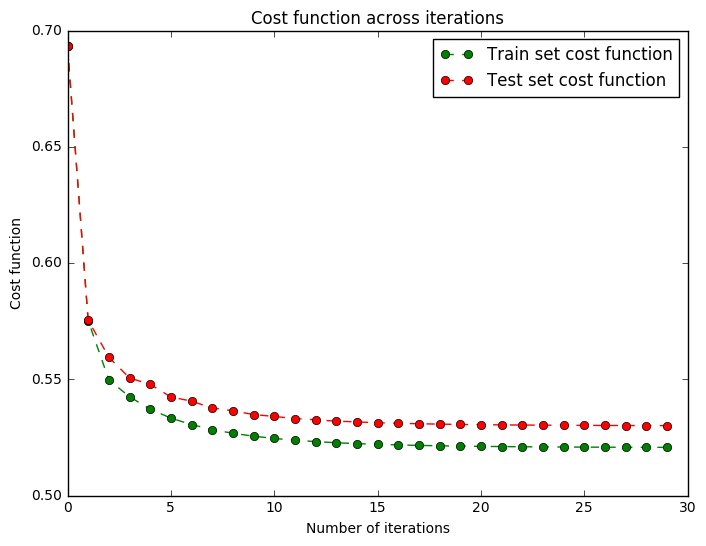

In [14]:
# graph evolution de la cost function au cours des iterations
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(history_cost[0,:],color='g',marker='o',linestyle='dashed',label='Train set cost function')
ax1.plot(history_cost[1,:],color='r',marker='o',linestyle='dashed',label='Test set cost function')

ax1.set_xlim([0,30])
ax1.set_ylim([0.5,0.7])
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost function')
ax1.set_title('Cost function across iterations')
ax1.legend(loc='best')

# Mini Batch Gradient Descent

In [15]:
from operator import add
def change_index(row):
    values = row.split(";")
    index = np.random.randint(batch_size, size=1)[0]
    values[0]=str(index)
    return ';'.join(values)

In [16]:
def transform_rdd_mb(row):
    values = row.split(";")
    index = int(values[0])
    x = np.array([float(i) for i in values[1:-1]])
    y = float(values[-1])
    return index,(x,y)

In [17]:
def logistic_funct_mb(x,w):
    return (1. / (1. + np.exp(-np.dot(w,x))))
def logistic_gradient_mb(row):
    index=row[0]
    x = row[1][0][0]
    y = row[1][0][1]
    w = row[1][1]
    lg = logistic_funct_mb(x,w)
    penal = np.append(w[:-1],0)
    return (index,x*(lg-y)+0.1*penal)

In [18]:
def update_w(row):
    index=row[0]
    w=row[1][0]
    grad=row[1][1]
    update=w - (1)*grad
    return (index,update)

In [19]:
def cost_func_mb(row):
    index=row[0]
    x=row[1][0]
    y=int(row[1][1])
    lg = logistic_funct_mb(x,wb.value)
    return -(y*np.log(lg)+(1-y)*np.log(1-lg))

In [20]:
def get_confusion_matrix_mb(row):
    x=row[1][0]
    y=row[1][1]
    lg = logistic_funct_mb(x, wb.value)
    pred = 1*(lg>0.5)
    return (int(y),pred)

In [21]:
np.random.seed(1)
num_train = 68917
num_test = 25249
batch_size = 10
niter = 30
w_miniBatch = sc.parallelize([(batch, np.zeros(55)) for batch in range(batch_size)],2)
history_cost = np.zeros((2,niter))
rdd_train_miniBatch = rdd_train.map(change_index).map(transform_rdd_mb)
rdd_test_miniBatch = rdd_test.map(change_index).map(transform_rdd_mb)

for i in range(niter):
    print(i)
    rdd_xyw = rdd_train_miniBatch.join(w_miniBatch)\
                            .coalesce(2)
    
    # compute gradient for each minibatch
    grad = rdd_xyw.map(logistic_gradient_mb)\
                  .mapValues(lambda v: (v, 1)) \
                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
                  .mapValues(lambda v: v[0]/v[1]) 

    # update coef
    w_miniBatch = w_miniBatch.join(grad).map(update_w).coalesce(2)
    
    # compute average coef across minibatch
    w_mean = w_miniBatch.map(lambda row: row[1]).mean()
    wb = sc.broadcast(w_mean)
    
    # train set cost function
    J_train = rdd_train_miniBatch.map(cost_func_mb).reduce(add)
    J_train = (J_train + (0.1*np.dot(wb.value[:-1],wb.value[:-1])/2))/num_train
    # test set cost function
    J_test = rdd_test_miniBatch.map(cost_func_mb).reduce(add)
    J_test = (J_test + (0.1*np.dot(wb.value[:-1],wb.value[:-1])/2))/num_test
    
    # save cost
    history_cost[:,i] = J_train, J_test
    print("J_train: %.4g" % J_train)
    print("J_test: %.4g" % J_test)
    
# score train_set
score_train = rdd_train_miniBatch.map(
    lambda row: get_confusion_matrix_mb(row)).map(
    lambda kv:(kv,1)).reduceByKey(
    lambda x, y: x + y) 
conf_mat_train = score_train.collect()
print('Train set confusion matrix',conf_mat_train)

# score test_set
score_test = rdd_test_miniBatch.map(
    lambda row: get_confusion_matrix_mb(row)).map(
    lambda kv:(kv,1)).reduceByKey(
    lambda x, y: x + y) 
conf_mat_test = score_test.collect()
print('Test set confusion matrix',conf_mat_test)

0
J_train: 0.5752
J_test: 0.5755
1
J_train: 0.5498
J_test: 0.5595
2
J_train: 0.5425
J_test: 0.5505
3
J_train: 0.5371
J_test: 0.5477
4
J_train: 0.5333
J_test: 0.5423
5
J_train: 0.5305
J_test: 0.5405
6
J_train: 0.5284
J_test: 0.5375
7
J_train: 0.5268
J_test: 0.5365
8
J_train: 0.5255
J_test: 0.5347
9
J_train: 0.5245
J_test: 0.534
10
J_train: 0.5238
J_test: 0.533
11
J_train: 0.5232
J_test: 0.5325
12
J_train: 0.5227
J_test: 0.532
13
J_train: 0.5223
J_test: 0.5316
14
J_train: 0.522
J_test: 0.5313
15
J_train: 0.5217
J_test: 0.5311
16
J_train: 0.5215
J_test: 0.5308
17
J_train: 0.5214
J_test: 0.5308
18
J_train: 0.5212
J_test: 0.5306
19
J_train: 0.5211
J_test: 0.5304
20
J_train: 0.521
J_test: 0.5304
21
J_train: 0.5209
J_test: 0.5303
22
J_train: 0.5209
J_test: 0.5302
23
J_train: 0.5208
J_test: 0.5302
24
J_train: 0.5208
J_test: 0.5301
25
J_train: 0.5208
J_test: 0.5301
26
J_train: 0.5207
J_test: 0.53
27
J_train: 0.5207
J_test: 0.53
28
J_train: 0.5207
J_test: 0.53
29
J_train: 0.5206
J_test: 0.53
Tra

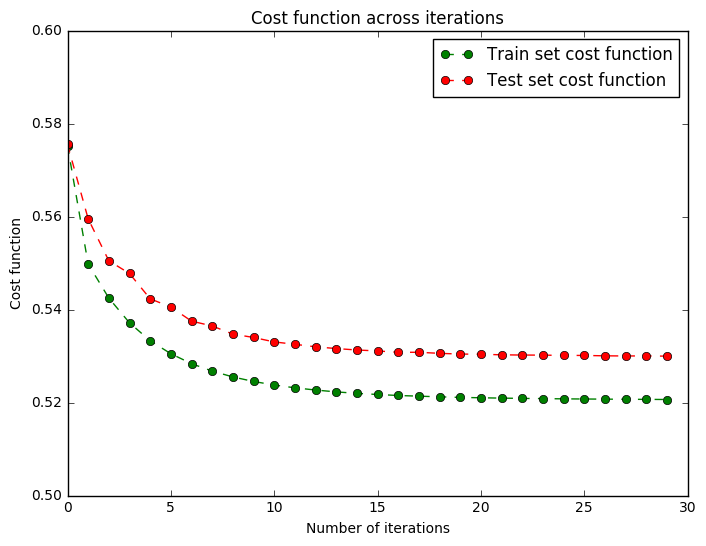

In [22]:
# graph evolution de la cost function au cours des iterations
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(history_cost[0,:],color='g',marker='o',linestyle='dashed',label='Train set cost function')
ax1.plot(history_cost[1,:],color='r',marker='o',linestyle='dashed',label='Test set cost function')

ax1.set_xlim([0,30])
ax1.set_ylim([0.5,0.6])
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost function')
ax1.set_title('Cost function across iterations')
ax1.legend(loc='best')